In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import ADASYN, SMOTE

In [ ]:
features = pd.read_csv('./Dyt-desktop.csv', delimiter=';').columns.values[:-1]

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load the dataset
data = pd.read_csv("./Dyt-desktop.csv", delimiter=';')  # adjust path
print(data['Dyslexia'].value_counts())



# Encode categorical columns using LabelEncoder (converts to 0/1 if binary)
label_cols = ['Gender']
le = LabelEncoder()

for col in label_cols:
    data[col] = le.fit_transform(data[col])
    
data['Nativelang'] = data['Nativelang'].map({'Yes': 1, 'No': 0})
data['Otherlang'] = data['Otherlang'].map({'Yes': 1, 'No': 0})


if data['Dyslexia'].dtype == object:
    data['Dyslexia'] = le.fit_transform(data['Dyslexia'])

y=data['Dyslexia']
X=data.drop(columns=['Dyslexia'])
# Standardize numerical columns
exclude_cols = [col for col in X.columns if col.startswith('Accuracy')]
cols_to_scale = [col for col in X.columns if col not in exclude_cols]
scaler = MinMaxScaler(feature_range=(0,1))
#X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

# (Optional) convert 'Dyslexia' column to 0/1 if not already


# ✅ Final dataset ready for model
#print(data.head())

print(X.head(2))
print(y.head(3))

def load_data(path):
    data = pd.read_csv(path, delimiter=';')

    # Extract data points (features) as a NumPy array
    X = data.iloc[:, :-1].values

    # Extract labels as a NumPy array
    y = data['Dyslexia'].values
    y = np.where(y == 'Yes', 1, 0)

    return X, y

def pre_process(data, labels):
    X, y = data, labels

    # Replace NaN values with 0s
    # for i in range(X.shape[0]):
    #     for j in range(X.shape[1]):
    #         X[i][j] = np.nan_to_num(X[i][j])

    # Encode 'Male' to 0 and 'Female' to 1
    X[:, 0] = np.where(X[:, 0] == 'Male', 0, 1)

    # Encode 'Yes' to 1 and 'No' to 0
    X[:, 1] = np.where(X[:, 1] == 'Yes', 1, 0)
    X[:, 2] = np.where(X[:, 2] == 'Yes', 1, 0)

    # Perform Min-Max scaling for non-'Accuracy' columns
    scaler = MinMaxScaler(feature_range=(0, 1))
    for i, feature in enumerate(features):
        if not feature.startswith('Accuracy'):
            column_values = X[:, i].astype(float).reshape(-1, 1)
            X[:, i] = scaler.fit_transform(column_values).flatten()
    
    return X, y

def cross_validate(X, y, n_folds=10, threshold=0.5, seed=42, oversampling=None):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    accuracies = []
    recalls = []
    precisions = []
    rocs = []
    f1_scores = []
    
    for train, test in kf.split(X):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]

        if oversampling == 'smote':
            oversampler = SMOTE(random_state=seed)
        if oversampling == 'adasyn':
            oversampler = ADASYN(random_state=seed)
        if oversampling is not None:
            X_train, y_train = oversampler.fit_resample(X_train, y_train)
    return X_train,y_train,X_test,y_test

Dyslexia
No     3252
Yes     392
Name: count, dtype: int64
   Gender  Nativelang  Otherlang  Age  Clicks1  Hits1  Misses1  Score1  \
0       1           0          1    7       10     10        0      10   
1       0           1          1   13       12     12        0      12   

   Accuracy1  Missrate1  ...  Misses31  Score31  Accuracy31  Missrate31  \
0        1.0        0.0  ...         0        0    0.000000         0.0   
1        1.0        0.0  ...         0        4    0.114286         0.0   

   Clicks32  Hits32  Misses32  Score32  Accuracy32  Missrate32  
0        17       2         0        2    0.117647    0.000000  
1        26       2         2        2    0.076923    0.076923  

[2 rows x 196 columns]
0    0
1    1
2    0
Name: Dyslexia, dtype: int32


In [53]:
# data, labels = load_data('./Dyt-desktop.csv')
# data, labels = pre_process(data, labels)
# X_train,y_train,X_test,y_test = cross_validate(data,labels,oversampling='adasyn')
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
kf = KFold(n_splits=10,shuffle=True,random_state=42)
model = CatBoostClassifier(
    iterations=1500,  # Number of trees
    depth=6,  # Tree depth
    learning_rate=0.03,  # Controls step size
    loss_function='Logloss',  # For binary classification
    eval_metric='F1',
    verbose=0,
    class_weights = {0: 1.0, 1:6.0 }
    #3252 / 392
)
all_y_pred = []
all_y_test = []
ada = ADASYN(random_state=42)
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
#for train_index, test_index in skf.split(X,y):    
    model = CatBoostClassifier(
        iterations=1500,  # Number of trees
        depth=6,  # Tree depth
        learning_rate=0.03,  # Controls step size
        loss_function='Logloss',  # For binary classification
        eval_metric='F1',
        verbose=0,
        class_weights = {0: 1.0, 1:6.0 }
    #3252 / 392
)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply ADASYN only on the training data
    
    
    X_train, y_train = ada.fit_resample(X_train, y_train)
    
    model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)
    y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class ("Yes")
    threshold = 0.6  # Adjust this based on precision-recall tuning
    
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    auc_pr = auc(recall, precision)  # or use average_precision_score(y_test, y_prob)

    print(f"Fold {fold} PR-AUC: {auc_pr:.4f}")
    
    y_pred_threshold = (y_prob >= threshold).astype(int)
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred_threshold)

print("Overall Accuracy:", accuracy_score(all_y_test, all_y_pred))
print(classification_report(all_y_test, all_y_pred))


Fold 0 PR-AUC: 0.3664
Fold 1 PR-AUC: 0.5435
Fold 2 PR-AUC: 0.5188
Fold 3 PR-AUC: 0.5700
Fold 4 PR-AUC: 0.4174
Fold 5 PR-AUC: 0.3449
Fold 6 PR-AUC: 0.4958
Fold 7 PR-AUC: 0.3958
Fold 8 PR-AUC: 0.6341
Fold 9 PR-AUC: 0.4773
Overall Accuracy: 0.7755214050493963
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      3252
           1       0.29      0.75      0.42       392

    accuracy                           0.78      3644
   macro avg       0.63      0.77      0.64      3644
weighted avg       0.89      0.78      0.81      3644



In [ ]:
train_acc = accuracy_score(y_train, model.predict(X_train))
test_acc = accuracy_score(y_test, model.predict(X_test))

print(train_acc)
print(test_acc)

0.8874013044970821
0.739010989010989


Accuracy: 0.7335164835164835
              precision    recall  f1-score   support

           0       0.98      0.71      0.83       325
           1       0.27      0.90      0.42        39

    accuracy                           0.73       364
   macro avg       0.63      0.81      0.62       364
weighted avg       0.91      0.73      0.78       364



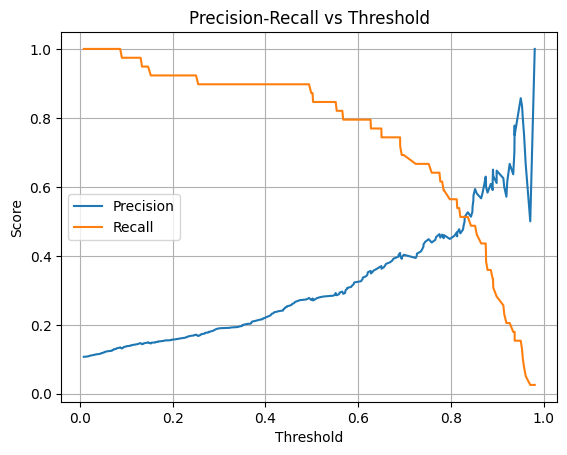

In [5]:
#best model 

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import shuffle



# Initialize the CatBoostClassifier
# model = CatBoostClassifier(
#     iterations=1500,  # Number of trees
#     depth=6,  # Tree depth
#     learning_rate=0.03,  # Controls step size
#     loss_function='Logloss',  # For binary classification
#     eval_metric='F1',
#     verbose=100,
#     class_weights = {0: 1.0, 1:6.0 }
#     #3252 / 392
# )

# # Train the model
# model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

# Make predictions
# y_pred = model.predict(X_test)

# # Evaluate model performance
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Test Accuracy: {accuracy:.4f}")
# print(classification_report(y_test, y_pred))
y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class ("Yes")
threshold = 0.48  # Adjust this based on precision-recall tuning
y_pred_threshold = (y_prob >= threshold).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred_threshold))
print(classification_report(y_test, y_pred_threshold))

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#y_probs = model.predict_proba(X_test)[:, 1]  # Get probabilities for positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision-Recall vs Threshold')
plt.grid()
plt.show()




In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

# Define a larger search space for hyperparameters
param_grid = {
    'C': [1, 10,100],  # More values for regularization
    'gamma': [1, 0.1, 0.01],  # Wider range for RBF gamma
    'kernel': ['rbf'],  # Keeping the best performing kernel
}

# Initialize SVC
svm_model = SVC(probability=True)

# Using RandomizedSearchCV for better hyperparameter tuning
'''random_search = RandomizedSearchCV(
    svm_model, param_distributions=param_grid,
    n_iter=20, cv=10, verbose=2, random_state=42, n_jobs=-1
)'''
random_search = GridSearchCV(
    svm_model, param_grid,
    cv=5, verbose=2, n_jobs=-1
)
random_search.fit(X_train, y_train)

# Best Parameters
print(f"Best Parameters: {random_search.best_params_}")
best_model = random_search.best_estimator_
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}")

# report = classification_report(y_test, y_pred)
# print(report)

# def predict_data(info):
#     print(best_model.predict(info))
y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class ("Yes")
threshold = 0.3  # Adjust this based on precision-recall tuning
y_pred_threshold = (y_prob >= threshold).astype(int)

print(classification_report(y_test, y_pred_threshold))

In [57]:
model = RandomForestClassifier(n_estimators=200, class_weight=None, random_state=42)
model.fit(X_train,y_train)
y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class ("Yes")
threshold = 0.35  # Adjust this based on precision-recall tuning
y_pred_threshold = (y_prob >= threshold).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred_threshold))
print(classification_report(y_test, y_pred_threshold))

Accuracy: 0.8763736263736264
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       321
           1       0.48      0.67      0.56        43

    accuracy                           0.88       364
   macro avg       0.72      0.79      0.75       364
weighted avg       0.90      0.88      0.88       364



In [21]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
base_learners = [
    ('catboost', CatBoostClassifier(
    iterations=1500,  # Number of trees
    depth=6,  # Tree depth
    learning_rate=0.03,  # Controls step size
    loss_function='Logloss',  # For binary classification
    eval_metric='Accuracy',verbose=100,)),  # CatBoostClassifier is already imported in CELL INDEX 3
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42,class_weight=None))
]

# Define meta learner (final estimator)
meta_learner = CatBoostClassifier(
    iterations=1500,  # Number of trees
    depth=6,  # Tree depth
    learning_rate=0.03,  # Controls step size
    loss_function='Logloss',  # For binary classification
    eval_metric='Accuracy',
    verbose=100,
)

# Create stacking ensemble
stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    passthrough=True,  # if you want to pass original features along with base model predictions
    n_jobs=-1
)

# Fit model
stacking_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = stacking_model.predict_proba(X_test)
y_prob = stacking_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class ("Yes")
threshold = 0.35  # Adjust this based on precision-recall tuning
y_pred_threshold = (y_prob >= threshold).astype(int)
print('proba')
print("Accuracy:", accuracy_score(y_test, y_pred_threshold))
print(classification_report(y_test, y_pred_threshold))

print('normal')
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

0:	learn: 0.9583549	total: 34.8ms	remaining: 52.1s
100:	learn: 0.9809919	total: 1.84s	remaining: 25.5s
200:	learn: 0.9896319	total: 3.62s	remaining: 23.4s
300:	learn: 0.9937792	total: 5.39s	remaining: 21.5s
400:	learn: 0.9967168	total: 7.19s	remaining: 19.7s
500:	learn: 0.9979264	total: 8.98s	remaining: 17.9s
600:	learn: 0.9993088	total: 10.8s	remaining: 16.1s
700:	learn: 0.9998272	total: 12.6s	remaining: 14.3s
800:	learn: 1.0000000	total: 14.3s	remaining: 12.5s
900:	learn: 1.0000000	total: 16.1s	remaining: 10.7s
1000:	learn: 1.0000000	total: 17.8s	remaining: 8.87s
1100:	learn: 1.0000000	total: 19.5s	remaining: 7.07s
1200:	learn: 1.0000000	total: 21.3s	remaining: 5.29s
1300:	learn: 1.0000000	total: 23s	remaining: 3.52s
1400:	learn: 1.0000000	total: 24.8s	remaining: 1.75s
1499:	learn: 1.0000000	total: 26.5s	remaining: 0us
proba
Accuracy: 0.8818681318681318
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       321
           1       0.50

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

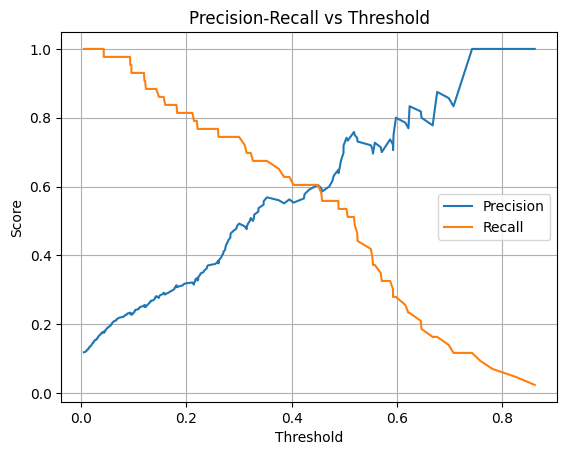

In [15]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_probs = model.predict_proba(X_test)[:, 1]  # Get probabilities for positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision-Recall vs Threshold')
plt.grid()
plt.show()


In [22]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
catboost_clf = CatBoostClassifier(
    verbose=0, 
    class_weights=[1, 5],
    random_state=42,
    iterations=1500,  # Number of trees
    depth=6,  # Tree depth
    learning_rate=0.03,  # Controls step size
    loss_function='Logloss',  # For binary classification
    eval_metric='Recall')
log_reg = LogisticRegression()

stacked_model = StackingClassifier(
    estimators=[('catboost', catboost_clf)],
    final_estimator=log_reg,
    cv=10,
    passthrough=True  # include original features in meta model
)

# Train and evaluate
stacked_model.fit(X_train, y_train)
y_pred = stacked_model.predict_proba(X_test)[:, 1]# Get probabilities for the positive class
threshold = 0.6
y_pred_threshold = (y_pred >= threshold).astype(int)  # Convert probabilities to binary predictions
print("Accuracy:", accuracy_score(y_test, y_pred_threshold))
print(classification_report(y_test, y_pred_threshold))

Accuracy: 0.8791208791208791
              precision    recall  f1-score   support

           0       0.96      0.90      0.93       321
           1       0.49      0.72      0.58        43

    accuracy                           0.88       364
   macro avg       0.73      0.81      0.76       364
weighted avg       0.90      0.88      0.89       364



c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


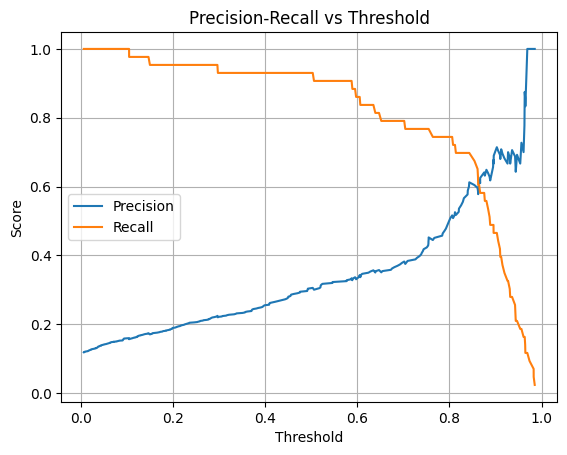

In [21]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_probs = model.predict_proba(X_test)[:, 1]  # Get probabilities for positive class
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision-Recall vs Threshold')
plt.grid()
plt.show()
